In [25]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
import autograd as ad
import autograd.numpy as np
from cosmatrix import cosm,expm_pade
expm = expm_pade
from autograd.extend import primitive, defvjp
def annihilation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),1)
def creation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),-1)
def coupled_spectrum(phi_ex,beta,N,Ej,Ec,omega_c,g_intfa):
    @primitive
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp
    defvjp(Us_min, phi_minde)
    
    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    c2 = beta*np.cos(phi_min - phi_ex) + 1/N*np.cos(phi_min/N)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2
    sdim = 10
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    Hs = (omega_s * np.matmul(sd,s)
        - Ej*(beta*cosm(phi_zpf*(s+sd)+(phi_min-phi_ex)*np.identity(sdim))
        + N*cosm((phi_zpf*(s+sd)+phi_min*np.identity(sdim))/N))- g2*x2)
    
    cdim = 10
    c = annihilation(cdim)
    cd = creation(cdim)
    Hc = omega_c*np.matmul(cd,c)
    Ic = np.identity(cdim)
    Is = np.identity(sdim)
    Hs = np.kron(Hs,Ic)
    Hc = np.kron(Is,Hc)
    g_int =  g_intfa*2*np.pi*np.power((2*Ec)/Ej,1/4)/phi_zpf
    H_int = g_int*np.kron(s+sd,cd+c)
#     H_int = g_int*(np.kron(sd,c)+np.kron(s,cd))
    H = Hs + Hc + H_int
    energy,dressed_states = np.linalg.eigh(H)
    energy = energy-energy[0]*np.ones(len(energy))
    exact = energy[1]/2/np.pi
    return exact, omega_s

def coupled_spectrumapp(phi_ex,beta,N,Ej,Ec,omega_c,g_intfa):
    @primitive
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp
    defvjp(Us_min, phi_minde)
    
    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    c2 = beta*np.cos(phi_min - phi_ex) + 1/N*np.cos(phi_min/N)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2
    sdim = 10
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    Hs = (omega_s * np.matmul(sd,s)
        - Ej*(beta*cosm(phi_zpf*(s+sd)+(phi_min-phi_ex)*np.identity(sdim))
        + N*cosm((phi_zpf*(s+sd)+phi_min*np.identity(sdim))/N))- g2*x2)
    
    energy,dressed_states = np.linalg.eigh(Hs)
    energy = energy-energy[0]*np.ones(len(energy))
    omega_sp = energy[1]
    c3 = (N**2-1)/N**2*np.sin(phi_min/N)
    g3 = Ej*phi_zpf**3*c3/3/2
    c4 = -beta*np.cos(phi_min-phi_ex) -1/N**3*np.cos(phi_min/N)

    g4 = Ej*phi_zpf**4*c4/4/3/2
    omega_s = omega_s
    g_int =  g_intfa*2*np.pi*np.power((2*Ec)/Ej,1/4)/phi_zpf
    deltap = omega_c - omega_sp
    addp = omega_c + omega_sp
    delta = omega_c - omega_s
    add = omega_c + omega_s
    x2 = np.matmul(s+sd,s+sd)
    x3 = np.matmul(s+sd,x2)
    x4 = np.matmul(s+sd,x3)
    Hs = omega_sp * np.matmul(sd,s) 
    cdim = 10
    c = annihilation(cdim)
    cd = creation(cdim)
    Hc = omega_c*np.matmul(cd,c)
    Ic = np.identity(cdim)
    Is = np.identity(sdim)
    Hs = np.kron(Hs,Ic)
    Hc = np.kron(Is,Hc)
    g_int =  g_intfa*2*np.pi*np.power((2*Ec)/Ej,1/4)/phi_zpf
    g_intfaA= g_intfa*2*np.pi*np.power((2*Ec)/Ej,1/4)
    p1 = - 6*g4*s +2*g3*s@s  - 6*g4*sd@s@s+g4*s@s@s 
    app2 = s+sd+1/omega_s*(-12*g3*sd@s+ p1 + np.transpose(p1.conjugate()))
    dressed_states_dagger = np.conjugate(dressed_states.transpose())
#     s_int = dressed_states_dagger@(s+sd)@dressed_states
    D = int_swt(g3,g4,omega_s,s,sd,1)[1]
    U = expm(-D)
    int_s = np.transpose(U.conjugate())@(s+sd)@U
    H_int = g_int*np.kron(app2,cd+c)
    H = Hs + Hc + H_int
    energy,dressed_states = np.linalg.eigh(H)
    energy = energy-energy[0]*np.ones(len(energy))
    exact = energy[1]/2/np.pi
    sigma = omega_c**2-omega_s**2
#     +20*(g3/omega_s)**2+300*(g4/omega_s)**2
    A = 2*(g_int)**2*omega_s/sigma
    B = g4
    C = 24*omega_s/sigma
    fac1 = 4*(Ej)*g_intfaA**2/sigma**2*c3*1.25
    fac2 = omega_c**2
    fac3 = 2*omega_s*Ec
    x1 = (g3**2/omega_s**2)*144*omega_s**3*(6*omega_s**2-omega_c**2)/(omega_c**6-6*omega_c**4*omega_s**2+9*omega_c**2*omega_s**4-4*omega_s**6)
    y1 = 48*omega_s**2*g4/(omega_c**2-omega_s**2)**2
    z1 = 2*omega_s/(omega_c**2-omega_s**2)
    return (x1+y1+z1)*g_int**2,A,B,C,c2,c4,fac1,fac2,fac3


In [26]:
from qutip import qload
from sympy.physics.secondquant import *
from sympy import symbols
import sympy as sp
from cosmatrix import expm_pade
def int_swt(g3,g4,omegas,s,sd,order):    
    s1,s2,s3 = qload('./symbolic/swt')
    omegasp = symbols('omega', real=True)
    g3sp = symbols('g3', real=True)
    g4sp = symbols('g4', real=True)
    omega = symbols('omega', real=True)
    kappa = symbols('kappa', real=True)
    ind_a = symbols('a')
    a = B(ind_a)
    ad = Bd(ind_a)
    def replace_scalars_with_valued_matrices(expr, matrix_values):
        """
        Replace scalar symbols and scalar operations in a SymPy scalar expression with valued matrices.

        Args:
        expr (sympy.Expr): The input scalar expression.
        matrix_values (dict): A dictionary mapping scalar symbols to valued matrices.

        Returns:
        sympy.Expr: The modified expression with valued matrices.
        """

        def map_operations(node):
            if (isinstance(node, AnnihilateBoson) or isinstance(node, CreateBoson) )and node in matrix_values:
                return matrix_values[node]
            elif isinstance(node, sp.Add):
                return sp.Add(*[map_operations(arg) for arg in node.args])
            elif isinstance(node, sp.Mul):
                return sp.Mul(*[map_operations(arg) for arg in node.args])
            elif isinstance(node, sp.Pow):
                base, exponent = map_operations(node.base), map_operations(node.exp)
                return base**exponent
            else:
                return node

        return map_operations(expr)
    def smatrix(expr):
        expr = expr.subs({ g3sp:g3[0],g4sp:g4[0], kappa:1,omegasp:omegas[0]})
        sp_s = sp.Matrix(s)
        sp_sd = sp.Matrix(sd)
        matrix_values = {a: sp_s, ad: sp_sd}
        result = replace_scalars_with_valued_matrices(expr, matrix_values)
        return np.array(result,np.float64)
    if order == 1:
        D = smatrix(s1)
    if order == 2:
        D = smatrix(s1) + smatrix(s2) 
    if order == 3:
        D = smatrix(s1) + smatrix(s2) + smatrix(s3)
    app = expm(D)@(s+sd)@expm(-D)
    return app,D

In [27]:
beta = 0.1
omega_c = 2.7*2*np.pi
g_intfa=0.15
N = 3
Ej = 15*2*np.pi
Ec = 0.7*2*np.pi
phi_exs = np.linspace(0.0*2*np.pi,0.5*2*np.pi,100)
grad = ad.grad(coupled_spectrum)
snail_energies = np.zeros(len(phi_exs))
snail_energiesapp1 = np.zeros(len(phi_exs))
snail_energiesapp2 = np.zeros(len(phi_exs))
snail_energiesapp3 = np.zeros(len(phi_exs))
dressed_omegas = np.zeros(len(phi_exs))
g4s = np.zeros(len(phi_exs))
g3s = np.zeros(len(phi_exs))
omega_sps = np.zeros(len(phi_exs))
Hs34 = np.zeros(len(phi_exs))
facs = np.zeros(len(phi_exs))
h = 1e-4  # step size

# Arrays to store derivatives
deriv_snail_energies = np.zeros(len(phi_exs))
deriv_snail_energiesapp3 = np.zeros(len(phi_exs))
deriv_snail_energiesapp4 = np.zeros(len(phi_exs))
deriv_snail_energiesapp5 = np.zeros(len(phi_exs))
deriv_snail_energiesapp6 = np.zeros(len(phi_exs))
deriv_snail_energiesapp7 = np.zeros(len(phi_exs))
for i in range(1, len(phi_exs)-1):  # Avoiding the endpoints
    snail_energies[i],dressed_omegas[i] = coupled_spectrum(phi_exs[i],beta,N,Ej,Ec,omega_c,g_intfa)
    snail_energiesapp3[i],As,Bs,Cs,c2,c4,fac1,fac2,fac3,= coupled_spectrumapp(phi_exs[i],beta,N,Ej,Ec,omega_c,g_intfa)
    snail_energy_plus, _ = coupled_spectrum(phi_exs[i] + h, beta, N, Ej, Ec, omega_c, g_intfa)
    snail_energy_minus, _ = coupled_spectrum(phi_exs[i] - h, beta, N, Ej, Ec, omega_c, g_intfa)

    snail_energiesapp3_plus,Aplus,Bplus,Cplus,c2plus,c4plus,_,_,_ = coupled_spectrumapp(phi_exs[i] + h, beta, N, Ej, Ec, omega_c, g_intfa)
    snail_energiesapp3_minus,Aminus,Bminus,Cminus,c2minus,c4minus,_,_,_= coupled_spectrumapp(phi_exs[i] - h, beta, N, Ej, Ec, omega_c, g_intfa)
    c2dot = (c2plus-c2minus)/(2*h)
    c4dot = (c4plus-c4minus)/(2*h)
    deriv_snail_energies[i] = (snail_energy_plus - snail_energy_minus) / (2 * h)
    deriv_snail_energiesapp3[i] = (snail_energiesapp3_plus - snail_energiesapp3_minus) / (2 * h)
    deriv_snail_energiesapp4[i] = (Aplus - Aminus) / (2 * h)/2/np.pi+As*(Bplus-Bminus)/2/h*Cs/2/np.pi
    deriv_snail_energiesapp5[i] = fac1*(-fac2+fac3*1.011)/2/np.pi

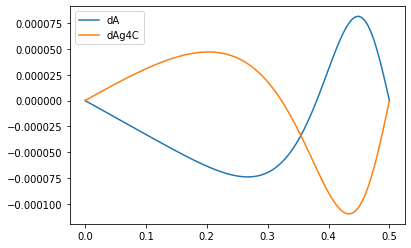

In [28]:
plt.plot(phi_exs/2/np.pi,deriv_snail_energiesapp4, label = 'dA')
plt.plot(phi_exs/2/np.pi,deriv_snail_energiesapp5, label = 'dAg4C')
# plt.plot(phi_exs/2/np.pi,deriv_snail_energiesapp6, label = 'dg4AC')
# plt.plot(phi_exs/2/np.pi,deriv_snail_energiesapp7, label = 'g4Adc')
plt.legend()

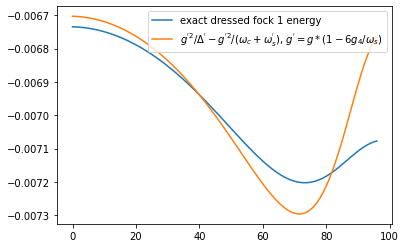

In [29]:
plt.plot((snail_energies-omega_c/2/np.pi*np.ones(100))[1:-2],label = 'exact dressed fock 1 energy')
# plt.scatter((phi_exs/2/np.pi)[-13],snail_energies[-14])
# plt.plot(phi_exs/2/np.pi,Hs34-omega_c/2/np.pi*np.ones(100), label = '1st order to $s+s^\dagger$')
# plt.plot(phi_exs/2/np.pi,snail_energiesapp2, label = '$g^2/\Delta - g^2/(\omega_c+\omega_s)$')
# plt.plot(phi_exs/2/np.pi,(snail_energiesapp3-omega_c/2/np.pi*np.ones(100)), label = '$g^2/\Delta - g^2/(\omega_c+\omega_s)$')
plt.plot((snail_energiesapp3)[1:-2]/2/np.pi, label = '$g^{\'2}/\Delta^{\'} - g^{\'2}/(\omega_c+\omega_s^{\'})$, $g^{\'}=g*(1-6g_4/ω_s)$')
plt.legend()

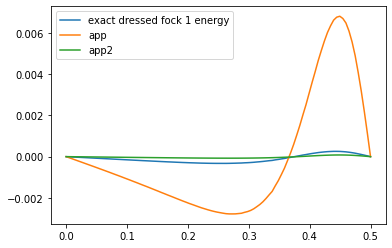

In [30]:
plt.plot(phi_exs/2/np.pi,deriv_snail_energies,label = 'exact dressed fock 1 energy')
# plt.scatter((phi_exs/2/np.pi)[-13],snail_energies[-14])
# plt.plot(phi_exs/2/np.pi,Hs34-omega_c/2/np.pi*np.ones(100), label = '1st order to $s+s^\dagger$')
# plt.plot(phi_exs/2/np.pi,snail_energiesapp2, label = '$g^2/\Delta - g^2/(\omega_c+\omega_s)$')
# plt.plot(phi_exs/2/np.pi,(snail_energiesapp3-omega_c/2/np.pi*np.ones(100)), label = '$g^2/\Delta - g^2/(\omega_c+\omega_s)$')
plt.plot(phi_exs/2/np.pi,deriv_snail_energiesapp3, label = 'app')
plt.plot(phi_exs/2/np.pi,deriv_snail_energiesapp4+deriv_snail_energiesapp6, label = 'app2')
plt.legend()

In [31]:
# check paramereters - g/delta
# calculate t2 - see improvement
# drive - engineer factor 

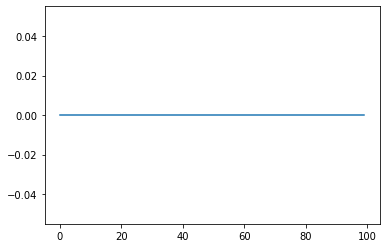

In [32]:
plt.plot(facs)

In [45]:
def coupled_spectrumapp(phi_ex,beta,N,Ej,Ec,omega_c):
    @primitive
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp
    defvjp(Us_min, phi_minde)
    
    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    c2 = beta*np.cos(phi_min - phi_ex) + 1/N*np.cos(phi_min/N)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2
    sdim = 10
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    c3 = (N**2-1)/N**2*np.sin(phi_min/N)
    g3 = Ej*phi_zpf**3*c3/3/2
    c4 = -beta*np.cos(phi_min-phi_ex) -1/N**3*np.cos(phi_min/N)
    g4 = Ej*phi_zpf**4*c4/4/3/2
    x2 = np.matmul(s+sd,s+sd)
    x3 = np.matmul(s+sd,x2)
    x4 = np.matmul(s+sd,x3)
    print(g3,g4)
    Hs = (omega_s * np.matmul(sd,s)
        - Ej*(beta*cosm(phi_zpf*(s+sd)+(phi_min-phi_ex)*np.identity(sdim))
        + N*cosm((phi_zpf*(s+sd)+phi_min*np.identity(sdim))/N))- g2*x2)
#     Hs = omega_s * np.matmul(sd,s) + g3*x3+g4*x4
    energy,dressed_states = np.linalg.eigh(Hs)
    energy = energy-energy[0]*np.ones(len(energy))
    omega_sp = energy[1]
    g_int =  0.15*2*np.pi*np.power((2*Ec)/Ej,1/4)/phi_zpf
    deltap = omega_c - omega_sp
    addp = omega_c + omega_sp
    delta = omega_c - omega_s
    add = omega_c + omega_s
    
    Hs = (omega_sp) * np.matmul(sd,s) 
    cdim = 10
    c = annihilation(cdim)
    cd = creation(cdim)
    Hc = omega_c*np.matmul(cd,c)
    Ic = np.identity(cdim)
    Is = np.identity(sdim)
    Hs = np.kron(Hs,Ic)
    Hc = np.kron(Is,Hc)
    g_int =  0.15*2*np.pi*np.power((2*Ec)/Ej,1/4)/phi_zpf
    dressed_states_dagger = np.conjugate(dressed_states.transpose())
#     s_int = dressed_states_dagger@(s+sd)@dressed_states
    D = int_swt(g3,g4,omega_s,s,sd,1)[0]
#     U = expm(-D)
#     int_s = np.transpose(U.conjugate())@(s+sd)@U
    H_int = g_int*np.kron(D,cd+c)
    H = Hs + Hc + H_int
    energy,dressed_states = np.linalg.eigh(H)
    energy = energy-energy[0]*np.ones(len(energy))
    exact1 = energy[1]/2/np.pi
    D = int_swt(g3,g4,omega_s,s,sd,2)[0]
#     U = expm(-D)
#     int_s = np.transpose(U.conjugate())@(s+sd)@U
    H_int = g_int*np.kron(D,cd+c)
    H = Hs + Hc + H_int
    energy,dressed_states = np.linalg.eigh(H)
    energy = energy-energy[0]*np.ones(len(energy))
    exact2 = energy[1]/2/np.pi
    return exact1,exact2


In [46]:
phi_exs = np.linspace(0.0*2*np.pi,0.5*2*np.pi,100)
grad = ad.grad(coupled_spectrum)
snail_energies = np.zeros(len(phi_exs))
snail_energiesapp1 = np.zeros(len(phi_exs))
snail_energiesapp2 = np.zeros(len(phi_exs))
snail_energiesapp3 = np.zeros(len(phi_exs))
dressed_omegas = np.zeros(len(phi_exs))
g4s = np.zeros(len(phi_exs))
g3s = np.zeros(len(phi_exs))
omega_sps = np.zeros(len(phi_exs))
Hs34 = np.zeros(len(phi_exs))
for i in range(len(phi_exs)):
    snail_energies[i],dressed_omegas[i] = coupled_spectrum(phi_exs[i],beta,N,Ej,Ec,omega_c,g_intfa)
    snail_energiesapp1[i],snail_energiesapp2[i]= coupled_spectrumapp(phi_exs[i],beta,N,Ej,Ec,omega_c)

[0.] [-0.11590776]
[0.01077549] [-0.1158907]
[0.02155069] [-0.11583951]
[0.03232415] [-0.11575416]
[0.0430961] [-0.11563457]
[0.05386468] [-0.11548067]
[0.06463017] [-0.11529234]
[0.07534361] [-0.11506912]
[0.08607623] [-0.11481127]
[0.09679619] [-0.1145184]
[0.10750197] [-0.11419027]
[0.11819162] [-0.11382661]
[0.12886344] [-0.11342712]
[0.13951558] [-0.11299146]
[0.15014595] [-0.11251928]
[0.16075263] [-0.11201017]
[0.17133348] [-0.11146373]
[0.18188615] [-0.11087948]
[0.19240835] [-0.11025695]
[0.20289769] [-0.1095956]
[0.21335179] [-0.10889488]
[0.22376778] [-0.10815421]
[0.2341426] [-0.10737293]
[0.24447368] [-0.10655041]
[0.25475773] [-0.10568594]
[0.26499131] [-0.10477877]
[0.27517112] [-0.10382814]
[0.28529342] [-0.10283323]
[0.2953544] [-0.10179319]
[0.30534964] [-0.10070711]
[0.31527509] [-0.09957407]
[0.32516559] [-0.09839433]
[0.33494322] [-0.09716463]
[0.34463704] [-0.09588493]
[0.3542416] [-0.09455415]
[0.36375073] [-0.09317112]
[0.37315871] [-0.09173466]
[0.38245865] [-0

KeyboardInterrupt: 

In [ ]:
plt.plot(phi_exs/2/np.pi,snail_energies,label = 'exact dressed fock 1 energy')
plt.plot(phi_exs/2/np.pi,snail_energiesapp1, label = '1st swt to $s+s^\dagger$')
plt.plot(phi_exs/2/np.pi,snail_energiesapp2, label = '2nd swt to $s+s^\dagger$')

plt.legend()